In [1]:
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
num_class = 33

# Base model without Fully connected Layers
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
x=base_model.output
# Add some new Fully connected layers to 
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(0.25)(x)
x=Dense(512,activation='relu')(x) 
x = Dropout(0.25)(x)
preds=Dense(num_class, activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

In [3]:
train_dir = "/home/asus/Desktop/Dataset_splits/train/"
test_dir = "/home/asus/Desktop/Dataset_splits/validation/"

In [4]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [5]:
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.25)

train_generator=train_datagen.flow_from_directory('/home/asus/Desktop/Dataset_splits/train/',
                                                 target_size=(224,224),
                                                 batch_size=128,
                                                 class_mode='categorical',
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory(
                                                '/home/asus/Desktop/Dataset_splits/validation/', # same directory as training data
                                                target_size=(224,224),
                                                batch_size=128,
                                                class_mode='categorical',
                                                subset='validation') # set as validation data

Found 16589 images belonging to 33 classes.
Found 1018 images belonging to 33 classes.


In [6]:
epochs = 40
learning_rate = 0.0005
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

!mkdir cckpt
!mkdir llogs

filepath="cckpt/best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only = False, save_best_only=True, mode='min')
logdir="llogs/mobilenet"
tfboard = TensorBoard(log_dir=logdir)

callbacks_list = [checkpoint, tfboard]

In [8]:
step_size_train = train_generator.n/train_generator.batch_size
step_size_val = validation_generator.samples // validation_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator, 
                   validation_steps =step_size_val,
                   callbacks = callbacks_list,
                   epochs=40)

Epoch 1/40
130/129 [==============================] - 1655s 13s/step - loss: 0.5652 - accuracy: 0.8280 - val_loss: 0.9023 - val_accuracy: 0.6931

Epoch 00001: val_loss improved from inf to 0.90231, saving model to cckpt/best.hdf5
Epoch 2/40
130/129 [==============================] - 1659s 13s/step - loss: 0.1812 - accuracy: 0.9382 - val_loss: 0.3369 - val_accuracy: 0.8831

Epoch 00002: val_loss improved from 0.90231 to 0.33686, saving model to cckpt/best.hdf5
Epoch 3/40
130/129 [==============================] - 1660s 13s/step - loss: 0.1412 - accuracy: 0.9530 - val_loss: 1.4508 - val_accuracy: 0.7124

Epoch 00003: val_loss did not improve from 0.33686
Epoch 4/40
130/129 [==============================] - 1679s 13s/step - loss: 0.1058 - accuracy: 0.9653 - val_loss: 0.3622 - val_accuracy: 0.8944

Epoch 00004: val_loss did not improve from 0.33686
Epoch 5/40
130/129 [==============================] - 1818s 14s/step - loss: 0.0816 - accuracy: 0.9721 - val_loss: 0.5292 - val_accuracy: 0.85

In [9]:
inf_model = keras.models.load_model("cckpt/best.hdf5")

In [10]:
def preprocess_image(img):
        if (img.shape[0] != 224 or img.shape[1] != 224):
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
        img = (img/127.5)
        img = img - 1
        img = np.expand_dims(img, axis=0)
        return img

In [11]:
classes = train_generator.class_indices
classes = list(classes.keys())

In [12]:
import glob
files = glob.glob("/home/asus/Desktop/anu33.jpg") 

In [13]:
from matplotlib import pyplot as plt

Tomato_Spider_mites_Two_spotted_spider_mite


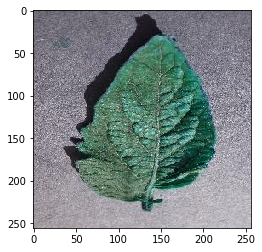

In [14]:
img = cv2.imread(files[0])
plt.imshow(img)
pred = inf_model.predict(preprocess_image(img))
result = classes[np.argmax(pred)]
print(result)     